In [1]:
# 描画のために必要になるもの
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 計算で必要になるもの
import numpy as np
import math
from scipy.stats import expon, norm

In [2]:
# 世界座標系におけるオブジェクト（ロボットやランドマーク）の管理を行うクラス
class World:
    def __init__(self, time_span, time_interval, debug=False):
        self.objects = [] # オブジェクトを入れる配列
        self.debug = debug # デバッグ用フラグ
        self.time_span = time_span # シミュレーション時間[s]
        self.time_interval = time_interval # サンプリング間隔
        
    # 配列にオブジェクトを追加する関数
    def append(self, obj):
        self.objects.append(obj)
        
    # 図の設定を行い、オブジェクトを描画する関数
    def draw(self):
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(-5,5)
        ax.set_ylim(-5,5)
        ax.set_xlabel("X", fontsize=20)
        ax.set_ylabel("Y", fontsize=20)
        
        # オブジェクトリスト
        elems = []
        
        #debug:Trueならばエラーメッセージが出力される
        if self.debug: # アニメーションなしで処理
            for i in range(1000):
                self.one_step(i, elems, ax)
        else: # アニメーションありで処理, frames:アニメのフレーム数（何回更新するか）、interval:フレーム間の時間
            self.ani = anm.FuncAnimation(fig, 
                                         self.one_step,
                                         fargs=(elems, ax),
                                         frames=int(self.time_span/self.time_interval)+1,
                                         interval=int(self.time_interval*1000),
                                         repeat=False)     
            plt.show()
        
    # アニメーションの1ステップの処理、iはステップ番号、elemsはオブジェクトリスト、axはサブプロット
    def one_step(self, i, elems, ax):
        # elemsの中身をすべて破棄
        while elems:
            elems.pop().remove()
        # 時間テキストを追加
        time_str = "t = %.2f[s]" % (self.time_interval*i)
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        # オブジェクトを描画
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"):
                obj.one_step(1.0)

In [3]:
# 標準的なロボットクラス
class IdealRobot:
    # 初期化する関数
    def __init__(self, pose, agent=None, sensor=None, color="black"):
        # ロボットの情報を初期化（位置姿勢、半径、色、エージェント、poseリスト）
        self.pose = pose
        self.r = 0.2
        self.color = color
        self.agent = agent
        self.poses = [pose]
        self.sensor = sensor
        
    # ロボットを描画する関数
    def draw(self, ax, elems):
        # ロボットの情報を用いて円を作成（向きに合わせて直線も引いている）
        x, y, theta = self.pose
        xn = x + self.r * math.cos(theta)
        yn = y + self.r * math.sin(theta)
        elems += ax.plot([x,xn], [y,yn], color=self.color)
        c = patches.Circle(xy=(x,y), radius=self.r, fill=False, color=self.color)
        # 引数のサブプロットへロボットを追加
        elems.append(ax.add_patch(c))
        
        # ax.plotはリストを返すので+=にする
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
   
    # 
    def one_step(self, time_interval):
        if not self.agent:
            return
        nu, omega = self.agent.decision()
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
     
    # @classmethodをつけることで外部から関数だけ呼び出せる
    @classmethod
    def state_transition(cls, nu, omega, time, pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array([nu*math.cos(t0),
                                     nu*math.sin(t0),
                                     omega]) * time
        else:
            return pose + np.array([nu/omega*(math.sin(t0+omega*time)-math.sin(t0)),
                                    nu/omega * (-math.cos(t0+omega*time) + math.cos(t0)),
                                    omega*time])

In [4]:
# エージェントを設置、とりあえず
class Agent:
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
        
    def decision(self, observation=None):
        return self.nu, self.omega

In [5]:
# IdealRobotを継承してRobotクラスを作成
class Robot(IdealRobot):
    def __init__(self, pose, agent=None, sensor=None, color="black", noise_per_meter=5, noise_std=math.pi/60, bias_rate_stds=(0.1, 0.1)):
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1])
        
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise -= nu*time_interval + self.r*omega*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
        return pose
    
    def bias(self, nu, omega):
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def one_step(self, time_interval):
        if not self.agent:
            return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)

<IPython.core.display.Javascript object>


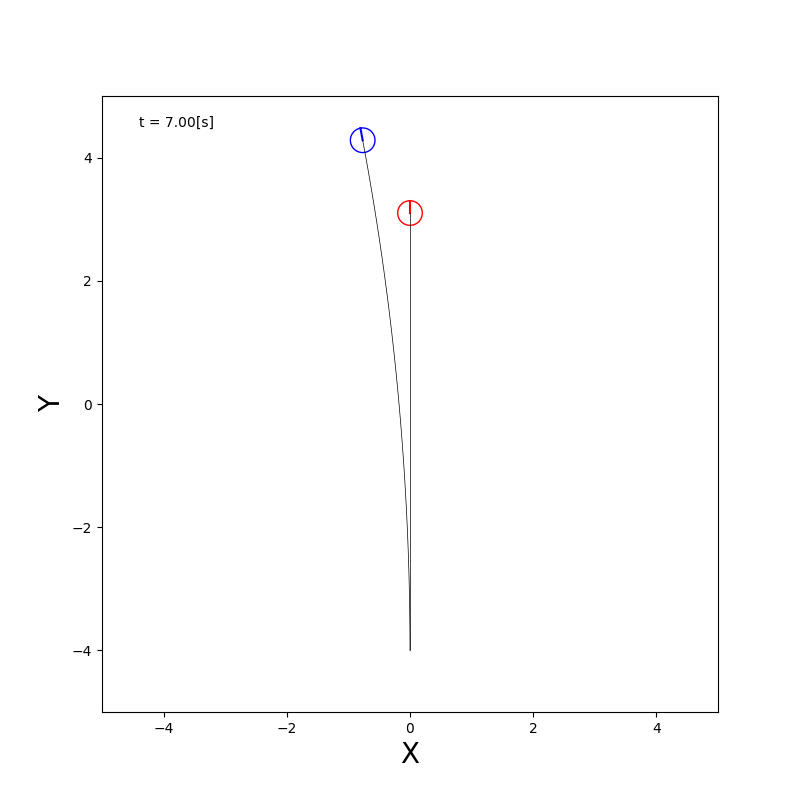

In [9]:
# time_span:シミュレート総時間、time_interval:サンプリング間隔
world = World(7, 0.1)

# 速度、角速度を定義
straight = Agent(0.1, 0.0)
bias_straight = Agent(0.1, 0.2/180*math.pi)

circling = Agent(0.1, 10.0/180*math.pi)

# オドメトリと実際の移動経路
odometry = IdealRobot(np.array([0, -4, math.pi/2]).T, sensor=None, agent=straight, color="red")
actual = Robot(np.array([0, -4, math.pi/2]).T, sensor=None, agent=bias_straight, color="blue", noise_per_meter=0, bias_rate_stds=(0.2, 0.2))

world.append(odometry)
world.append(actual)

world.draw()